In [1]:
#setting working directory
setwd('/Users/alexis/Documents/BIOS 635/Final Project')
Output = '/Users/alexis/Documents/BIOS 635/Final Project/Output'

library(tidyverse)
library(rlang)
library(reshape)
library(janitor)
library(caret)
library(factoextra)
library(gtsummary)
library(flextable)
library(pROC)
library(Hmisc)
library(viridis)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


Loading required package: lattice


Attaching package: ‘caret’


The following objec

In [2]:
#reading in data
food_data = read_csv("Food_Supply_kcal_Data.csv") %>%
  #first removing variables that aren't of interest (ie. not relevant, not a food group, or are unlikely to have an real impact)
  select(-Recovered, -Active, -`Unit (all except Population)`, -Obesity, -Undernourished, -Miscellaneous, -Spices) %>%
  drop_na() %>%
  #cases are per 100,000,000 people
  mutate(Confirmed_per_capita = Confirmed/Population * 100000000, Deaths_per_capita = Deaths/Population * 100000000) %>%
  #creating a column that specifies whether each country falls above or below the median
  mutate(Cases_vs_median = ifelse(Confirmed_per_capita > median(Confirmed_per_capita), "Above", "Below"), Deaths_vs_median = ifelse(Deaths_per_capita > median(Deaths_per_capita), "Above", "Below"))

head(food_data)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  Country = col_character(),
  Undernourished = col_character(),
  `Unit (all except Population)` = col_character()
)
ℹ Use `spec()` for the full column specifications.




Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,⋯,Vegetal Products,Vegetable Oils,Vegetables,Confirmed,Deaths,Population,Confirmed_per_capita,Deaths_per_capita,Cases_vs_median,Deaths_vs_median
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Afghanistan,0.0000,4.7774,0.8504,0,37.1186,0.1501,0.0000,1.4757,1.2006,⋯,45.2476,2.3012,0.7504,0.14213420,0.006185779,38928000,0.3651207,0.015890307,Below,Below
Albania,0.9120,16.0930,1.0591,0,16.2107,0.8091,0.1471,3.8982,3.8688,⋯,33.9070,2.8244,2.7508,2.96730092,0.050951374,2838000,104.5560577,1.795326787,Above,Above
Algeria,0.0896,6.0326,0.1941,0,25.0112,0.4181,0.1195,3.1805,1.2543,⋯,43.9749,5.7638,2.0457,0.24489709,0.006558153,44357000,0.5521047,0.014784934,Below,Below
Angola,1.9388,4.6927,0.2644,0,18.3521,0.0441,0.8372,2.3133,2.9302,⋯,45.3184,4.2741,0.3525,0.06168747,0.001460550,32522000,0.1896792,0.004490959,Below,Below
Antigua and Barbuda,2.3041,15.3672,1.5429,0,13.7215,0.2057,1.7280,3.6824,7.0356,⋯,34.6225,4.6904,1.2960,0.29387755,0.007142857,98000,299.8750521,7.288629738,Above,Above
Argentina,1.4354,14.9869,1.0650,0,16.7927,0.8643,0.2006,1.4663,9.4459,⋯,34.9900,5.5410,0.8643,4.35614739,0.108226635,45377000,9.5999017,0.238505487,Above,Above


First step will be to determine, which variables are collinear and need to be removed. For this analysis we're only interested in looking at both COVID-19 confirmed cases and deaths. 

In [3]:
##DO LATER!!
#just plotting to see what countries have the highest cases/deaths 
#consider making countries binary based upon low or high deaths/cases
#ggplot(food_data, aes(x = Cases_vs_median, y = `Per Capita Confirmed Cases`)) + 
  #geom_boxplot() + 

#creating correlation matrix
corr_matrix = rcorr(as.matrix(food_data[2:22]), type = "spearman")
#creating df where I can easily view coefficents that are highly correlated (rho > 0.7 or rho < -0.7)
corr_matrix_df = data.frame(corr_matrix$r) %>%
  rownames_to_column(var = "Variable1") %>%
  #needed to specificy package of melt for it to work
  reshape2::melt(variable = "Variable2", value.name = "Spearman Coefficient") %>%
  #also removed values = 1, because those were correlations between the same variable
  filter(abs(`Spearman Coefficient`) < 1 & abs(`Spearman Coefficient`) > 0.7) %>%
  arrange(desc(`Spearman Coefficient`)) %>%
  #removing duplicate spearman coefficient values and keeping all columns
  distinct(`Spearman Coefficient`, .keep_all = TRUE) 

corr_matrix_df

Using Variable1 as id variables



Variable1,Variable2,Spearman Coefficient
<chr>,<fct>,<dbl>
Meat,Animal.Products,0.8742046
Animal fats,Animal.Products,0.8482037
Milk - Excluding Butter,Animal.Products,0.7972005
Eggs,Animal.Products,0.7230595
Vegetal Products,Eggs,-0.7232907
Vegetal Products,Milk...Excluding.Butter,-0.7971923
Vegetal Products,Animal.fats,-0.8481602
Vegetal Products,Meat,-0.8742154
Vegetal Products,Animal.Products,-0.9999728


Based on these results, we should either remove animal products or remove meat, milk - excluding butter, and eggs. According to the metadata animal products include these 3 food groups.  

Preceding removing animal products, performing PCA first, and seeing how much of the variance was captured.

Warning message:
“ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


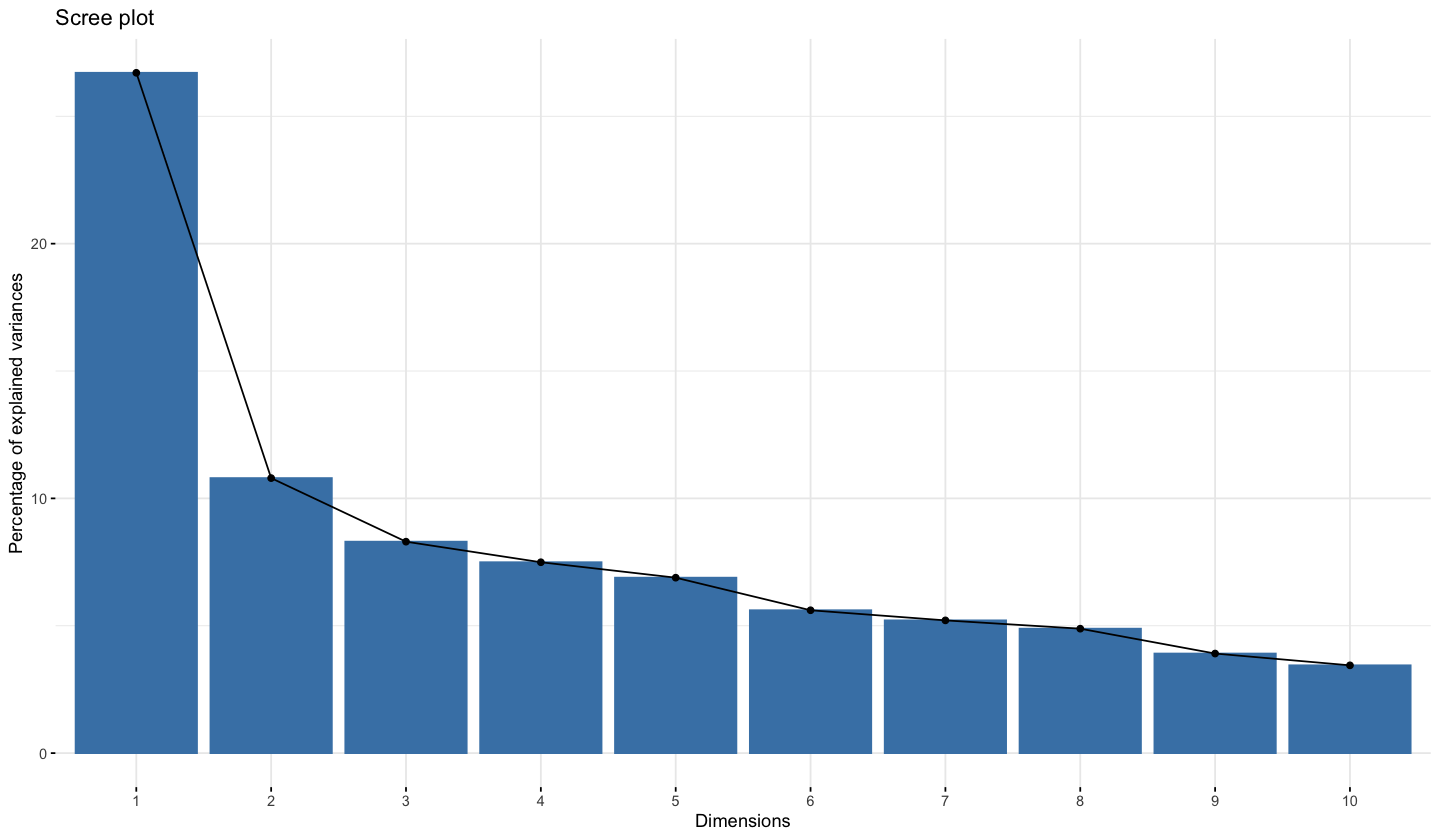

Warning message:
“ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


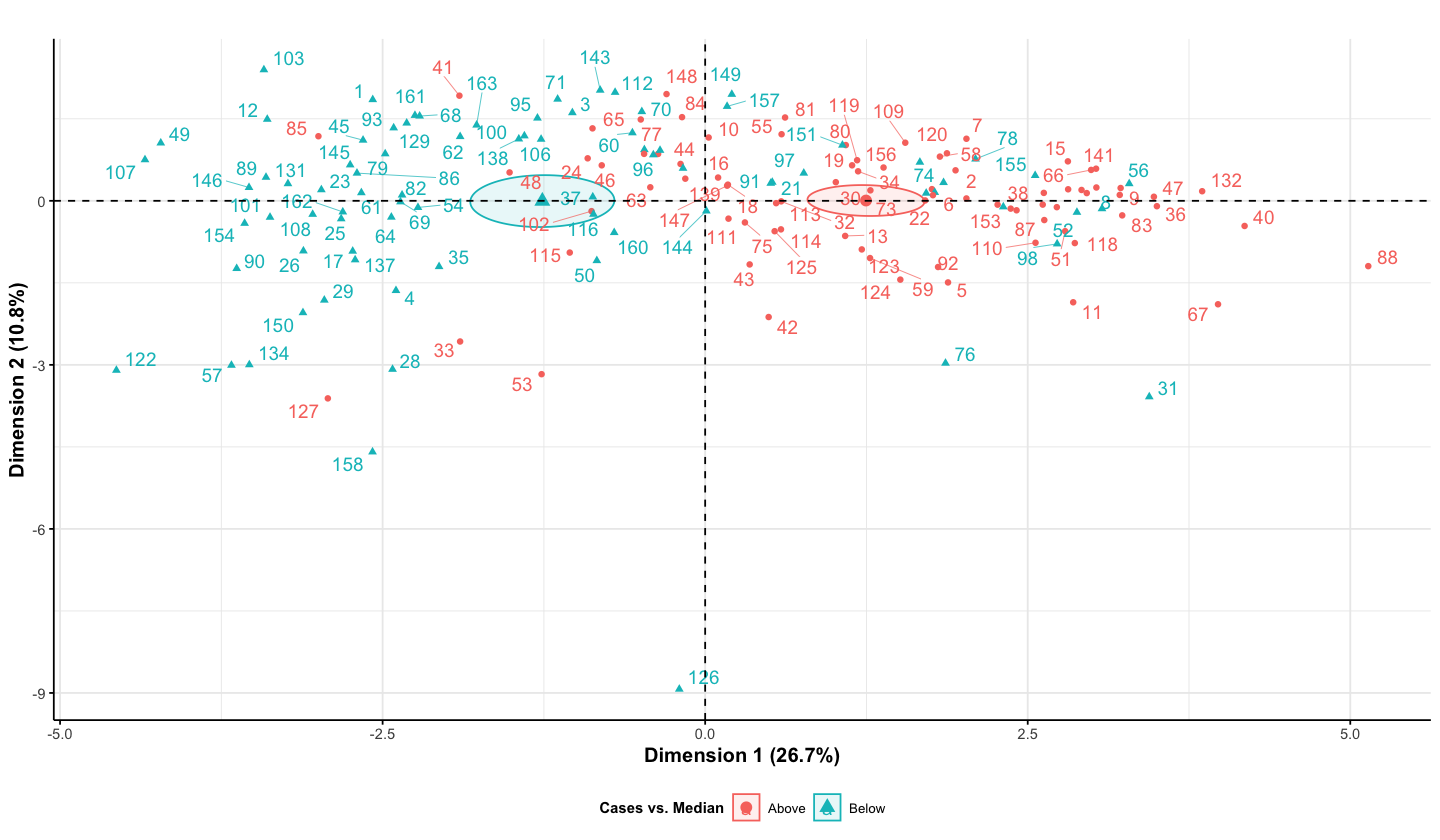

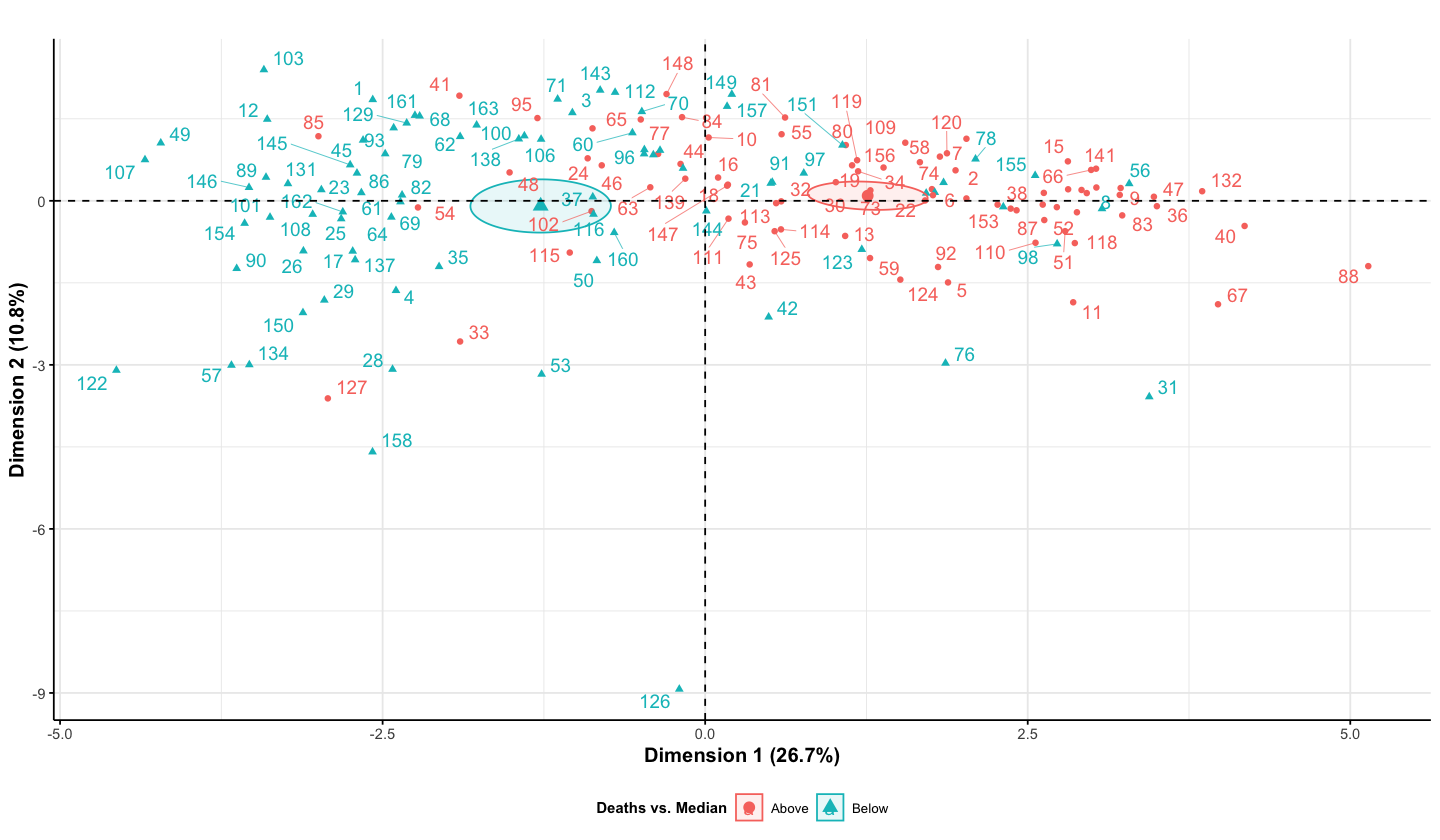

In [4]:
food_data = food_data %>%
  #removed animal products since it was easier
  select(-c(`Animal Products`, `Vegetal Products`)) %>%
  filter(Country != "Korea, South") #removing since this was an outlier in a cluster by itself


#running pca 
pca_food_data = prcomp(food_data[2:20], scale = TRUE)

#looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width=12, repr.plot.height=7) #changing size
fviz_eig(pca_food_data)

#do this after running kmeans and facet wrap by analysis type
cases_pca_plot = fviz_pca_ind(pca_food_data, 
             col.ind = food_data$Cases_vs_median, # color by cases_vs_median
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             legend.title = "Cases vs. Median",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) + #changes axis titles

  labs(x = "Dimension 1 (26.7%)", y = ("Dimension 2 (10.8%)")) 

cases_pca_plot

deaths_pca_plot = fviz_pca_ind(pca_food_data, 
             col.ind = food_data$Deaths_vs_median, # color by cases_vs_deaths
             #adding 95% confidence ellipses for each group
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             legend.title = "Deaths vs. Median",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 9, face = "bold"),
      legend.text = element_text(size = 8),
      legend.position = 'bottom',
      axis.title = element_text(face = "bold", size = rel(1.1))) + #changes axis titles

  labs(x = "Dimension 1 (26.7%)", y = ("Dimension 2 (10.8%)")) 

deaths_pca_plot

Quantifying each variable's weighted contribution to principal components by looking at loadings. Only looking at first principal component, since it captures a significantly larger portion of the variance. 

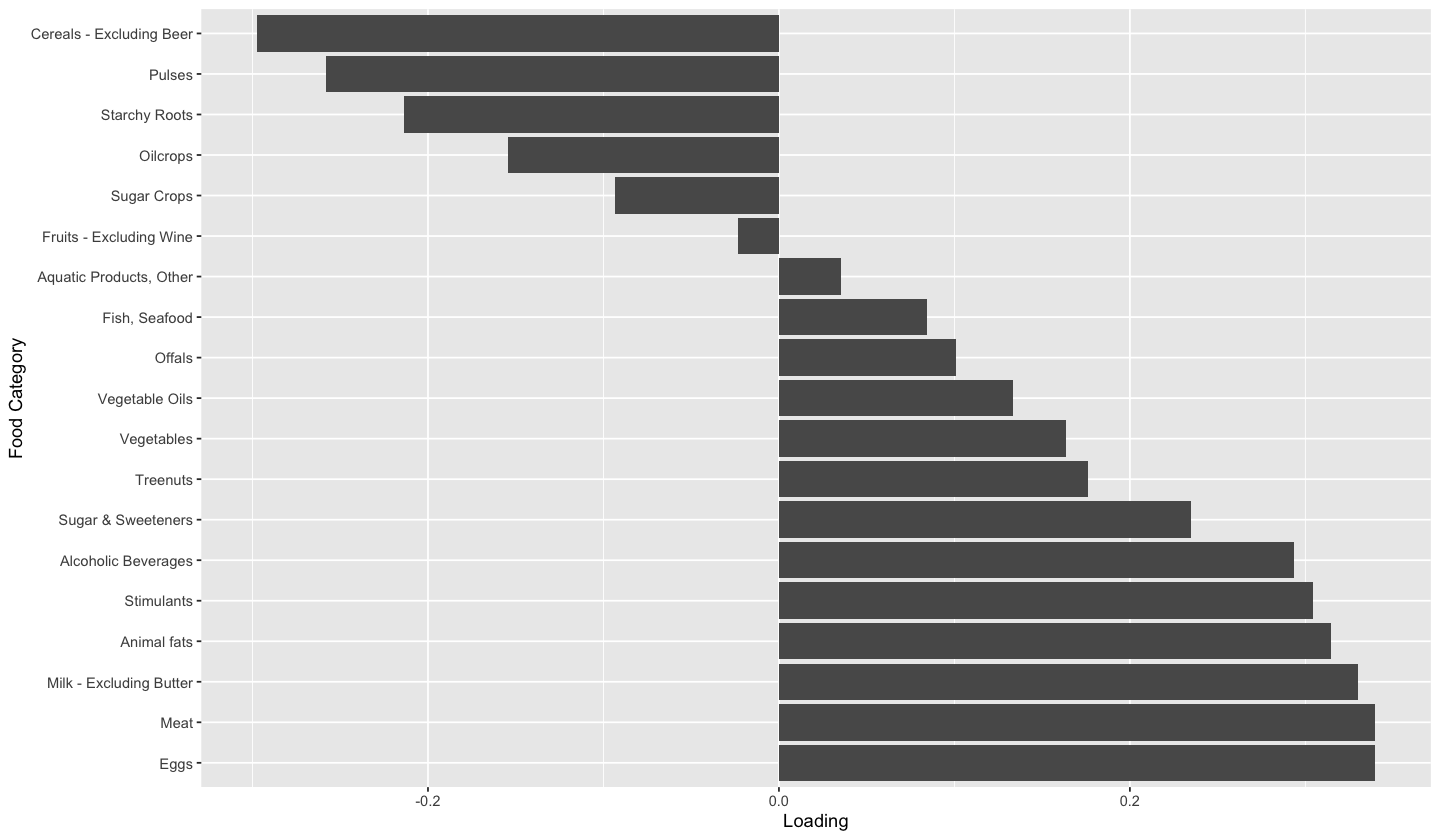

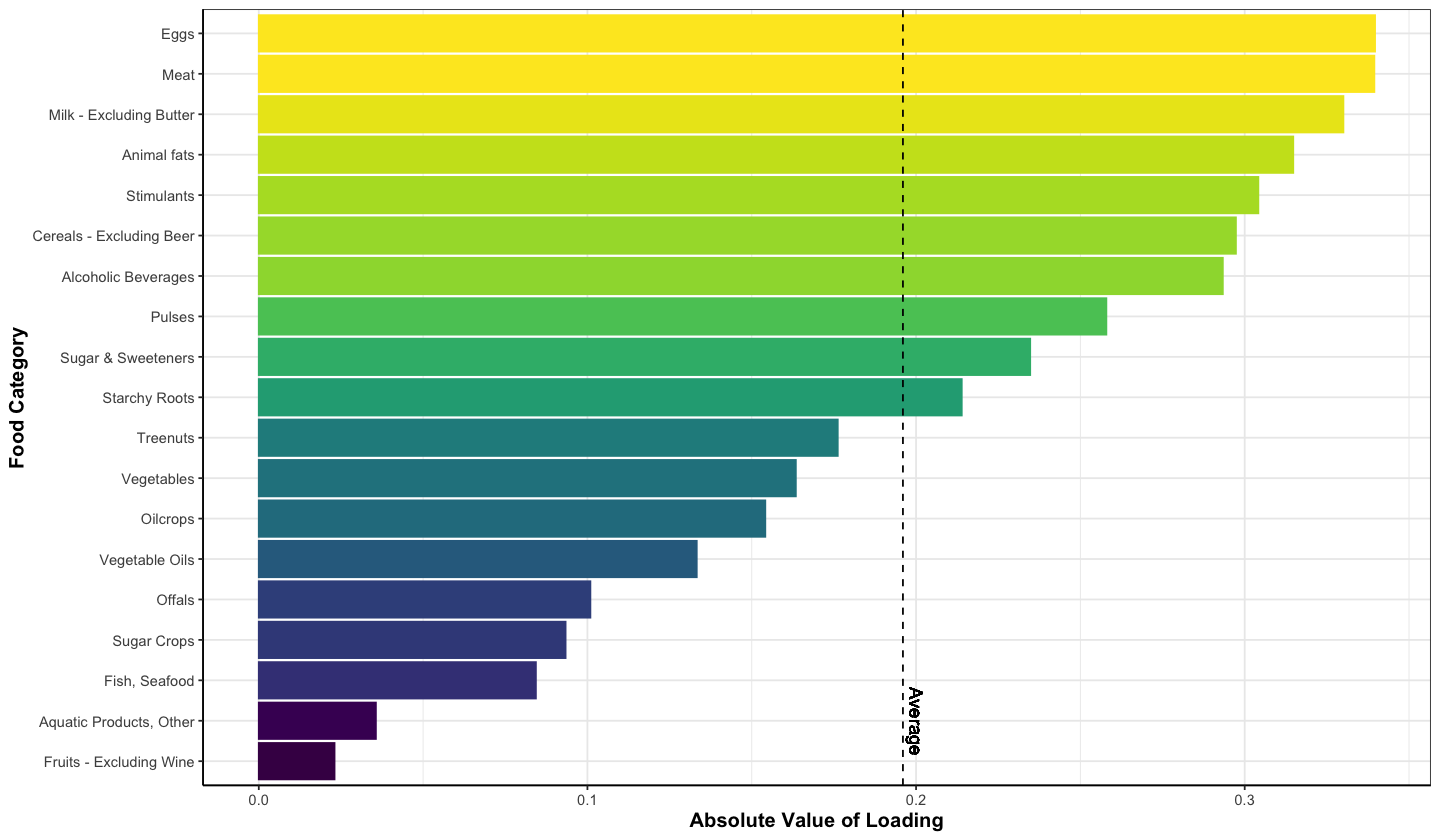

In [5]:
#looking at loadings
#trying to see what food categories have high loadings for a PC (what principal components are driven by what food groups?)
loadings = data.frame(pca_food_data$rotation) %>%
  rownames_to_column(var = "Food Category") %>%
  select(`Food Category`, PC1, PC2) %>%
  pivot_longer(cols = c("PC1", "PC2"), names_to = "PC", values_to = "Loading")

#version 1 
ggplot(loadings %>%
         #filtering for PC1
         filter(PC == "PC1"), 
       aes(y = reorder(`Food Category`, -Loading), x = Loading)) + 
  geom_bar(stat = "identity") + 
  #facet_wrap(~PC, ncol = 1, scales = 'free_y') 
  ylab("Food Category")

#version 2
Loadings_plot = ggplot(loadings %>%
         #filtering for PC1
         filter(PC == "PC1")) + 
  geom_col(aes(y = reorder(`Food Category`, abs(Loading)), x = abs(Loading), color = abs(Loading), fill = abs(Loading))) + 
  geom_vline(xintercept = mean(abs(loadings$Loading)), linetype = "dashed") + 
  geom_text(aes(x = mean(abs(loadings$Loading)), label = "Average\n", y = 2), angle = 270) +
  theme_bw() + 
  
  theme(axis.line = element_line(colour="black"), #making x and y axes black
        axis.title = element_text(face = "bold", size = rel(1.1)), #changes axis titles
        legend.position = "none") + #removing legend
  
  labs(x = "Absolute Value of Loading", y = ("Food Category")) + 
  scale_color_viridis() + 
  scale_fill_viridis()
  
Loadings_plot

Next, using kmeans to group countries into clusters. (Later realizing that unsupervised machine learning like kmeans doesn't make since, because we know what the outcome should be either cases or deaths. Therefore, we can still justify using PCA as means for dimension reduction for KNN.)

Cluster_Number,AIC,BIC
<int>,<dbl>,<dbl>
1,3280.000,3341.875
2,2655.205,2778.955
3,2468.054,2653.679
4,2310.846,2558.346
5,2193.816,2503.191
6,2107.352,2478.602
7,2031.311,2464.436
8,1992.239,2487.239
9,1965.538,2522.413


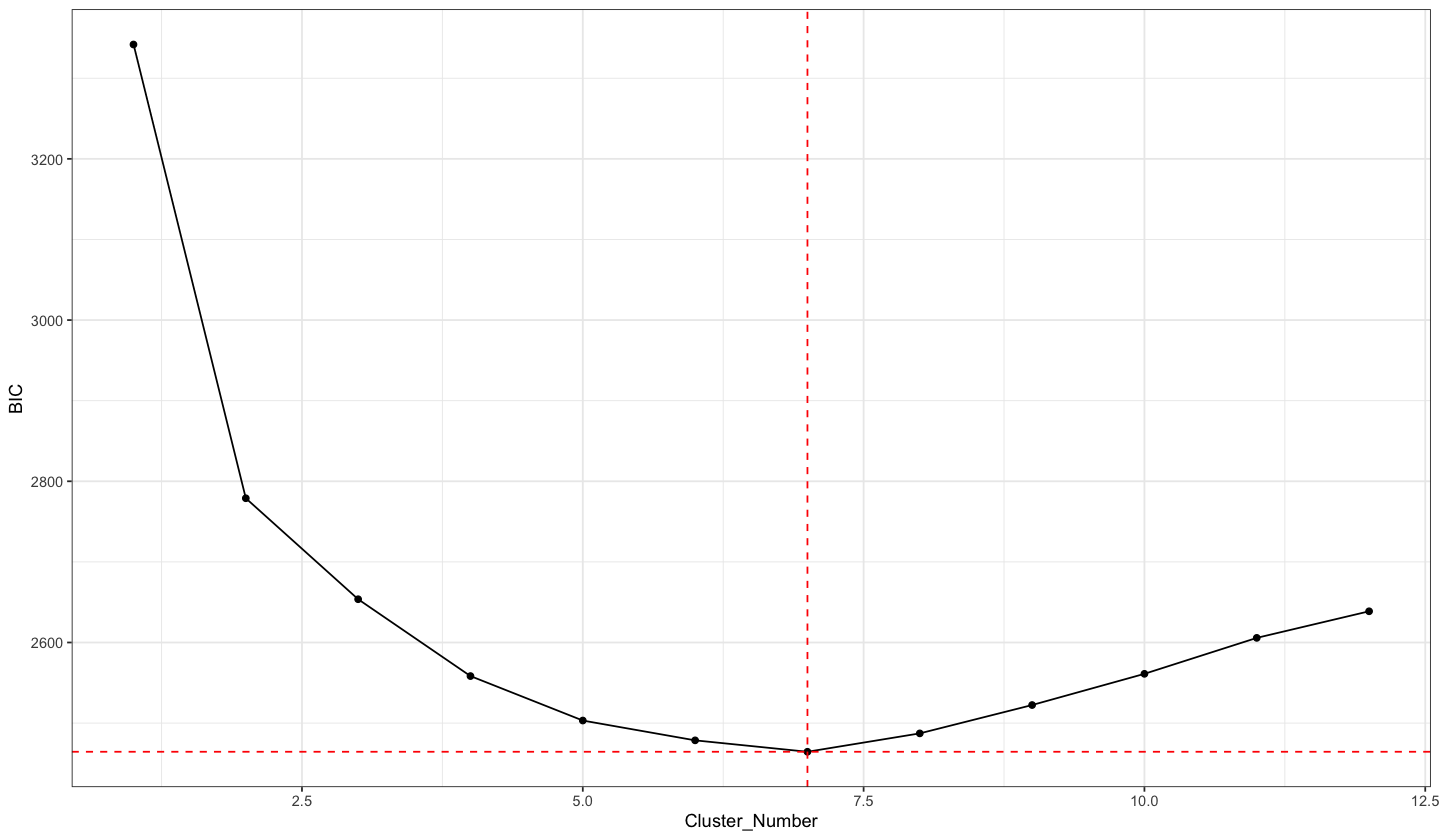

In [6]:
#determining the optimal number of clusters based on where BIC is minimized 
# Create function to compute AIC, BIC
kmeansAICBIC = function(fit){
  m = ncol(fit$centers)
  n = length(fit$cluster)
  k = nrow(fit$centers)
  D = fit$tot.withinss
  return(data.frame(AIC = D + 2*m*k,
                    BIC = D + log(n)*m*k))
}

#standardizing data
scaled_food_data = scale(food_data[,2:21]) #getting all the columns except the first which are countries 
clus <- list()
clustering_values = data.frame()
for (i in 1:12){
  clus[[i]] <- kmeans(x = scaled_food_data, centers = i, nstart = 10) #storing each cluster model 
  aic_bic <- kmeansAICBIC(clus[[i]])
  Cluster_Number <- i
  
  #saving values
  clustering_values = rbind(clustering_values, cbind(Cluster_Number, aic_bic))
}

clustering_values

#BIC vs. cluster # plot
clus_min_bic <-which(clustering_values$BIC == min(clustering_values$BIC))
ggplot(data = clustering_values, aes(x = Cluster_Number, y = BIC)) + 
  geom_point() + 
  geom_line() + 
  geom_vline(xintercept = clus_min_bic, linetype = "dashed", color = "red") + 
  geom_hline(yintercept = min(clustering_values$BIC), linetype = "dashed", color = "red") +
  theme_bw()

We can see that 7 is the optimal number of clusters. Therefore, we will predict COVID-19 cases and deaths continously per capita using these clusters. 

In [7]:
#creating new df with PCs and outcomes of interest
#countries, only using first 3 PCs based on scree plot and adding 2 outcomes
combined_df_continuous = data.frame(#Country = food_data$Country, #ids
                         "clus" = factor(clus[[clus_min_bic]]$cluster), #clustered data
                         pca_food_data$x[,1:3], #PCs
                         Confirmed_per_capita = food_data$Confirmed_per_capita, #outcomes
                         Deaths_per_capita = food_data$Deaths_per_capita) 


#now predicting with knn
set.seed(12)
#splitting data into training and testing sets
  combined_food_data_index = createFolds(combined_df_continuous$Deaths_per_capita, k = 10) #10 fold CV
  errors_continuous = data.frame()
  for (i in 1:length(combined_food_data_index)){
    combined_food_train = combined_df_continuous[-combined_food_data_index[[i]],]
    combined_food_test = combined_df_continuous[combined_food_data_index[[i]],]
      
    #training algorithm knn
    knn_fit_cases = train(Confirmed_per_capita ~ PC1 + PC2 + PC3, data = combined_food_train, method = 'knn', preProcess = c("center", "scale"), tuneLength = 20)
    knn_fit_deaths = train(Deaths_per_capita ~ PC1 + PC2 + PC3, data = combined_food_train, method = 'knn', preProcess = c("center", "scale"), tuneLength = 20)
  
    # testing algorithm on test set 
    combined_food_test$pred_cases = predict(knn_fit_cases, newdata = combined_food_test)
    combined_food_test$pred_deaths = predict(knn_fit_deaths, newdata = combined_food_test)
    
    #calculating MSE
    error_values_cases = postResample(combined_food_test$pred_cases, combined_food_test$Confirmed_per_capita)
    error_values_deaths = postResample(combined_food_test$pred_deaths, combined_food_test$Deaths_per_capita)

    #adding values to df
    errors_continuous = rbind(errors_continuous, cbind("Confirmed_per_capita", error_values_cases[1]^2))
    errors_continuous = rbind(errors_continuous, cbind("Deaths_per_capita", error_values_deaths[1]^2))
  
  }

colnames(errors_continuous) = c("Outcome", "MSE")
errors_continuous$MSE = as.numeric(errors_continuous$MSE) #needed to convert back into a numeric

#taking averages/sd
errors_continuous = errors_continuous %>%
  group_by(Outcome) %>%
  dplyr::summarize(`CV Error` = mean(MSE), `Std Error` = sd(MSE))


#viewing results
errors_continuous

,Outcome,CV Error,Std Error
,<fct>,<dbl>,<dbl>
1,Confirmed_per_capita,10,6.055301
2,Deaths_per_capita,11,6.055301


Unsure as to why the errors for cases are substantially larger than that for deaths, but seeing if KNN is better at predicting a binary outcome. 

In [8]:
#creating new df with PCs and outcomes of interest
#countries, only using first 3 PCs based on scree plot and adding 2 outcomes
combined_df_binary = data.frame(#Country = food_data$Country, #ids
                         "clus" = factor(clus[[clus_min_bic]]$cluster), #clustered data
                         pca_food_data$x[,1:3], #PCs
                         Cases_vs_median = food_data$Cases_vs_median, #outcomes
                         Deaths_vs_median = food_data$Deaths_vs_median) 

#need to make outcomes into factors for knn to work
combined_df_binary$Cases_vs_median = factor(combined_df_binary$Cases_vs_median)
combined_df_binary$Deaths_vs_median = factor(combined_df_binary$Deaths_vs_median)

#now predicting with knn
set.seed(12)
#splitting data into training and testing sets
combined_food_data_index = createFolds(combined_df_binary$Deaths_vs_median, k = 10) #10 fold CV
errors_binary = data.frame()
for (i in 1:length(combined_food_data_index)){
  combined_food_train = combined_df_binary[-combined_food_data_index[[i]],]
  combined_food_test = combined_df_binary[combined_food_data_index[[i]],]
      
  #training algorithm knn
  knn_fit_cases = train(Cases_vs_median ~ PC1 + PC2 + PC3, data = combined_food_train, method = 'knn', preProcess = c("center", "scale"), tuneLength = 20)
  knn_fit_deaths = train(Deaths_vs_median ~ PC1 + PC2 + PC3, data = combined_food_train, method = 'knn', preProcess = c("center", "scale"), tuneLength = 20)
  
  # testing algorithm on test set 
  combined_food_test$pred_cases = predict(knn_fit_cases, newdata = combined_food_test)
  combined_food_test$pred_deaths = predict(knn_fit_deaths, newdata = combined_food_test)
  cases_matrix = confusionMatrix(combined_food_test$pred_cases, combined_food_test$Cases_vs_median)
  deaths_matrix = confusionMatrix(combined_food_test$pred_deaths, combined_food_test$Deaths_vs_median)
    
  #calculating errors and adding to the same df
  cases_df = data.frame(t(c(cases_matrix$overall[1], cases_matrix$byClass[1:4]))) #extracting accuracy, sens, spec, PPV, NPV 
  deaths_df = data.frame(t(c(deaths_matrix$overall[1], deaths_matrix$byClass[1:4]))) #extracting accuracy, sens, spec, PPV, NPV 
  errors_binary = rbind(errors_binary, rbind(cases_df, deaths_df))
  
}

#need to outcome to ensure the results correspond with the correct outcome
errors_binary$Outcome = rep(c("Cases_vs_median", "Deaths_vs_median"), times = 5)

#taking averages/sd
errors_binary = errors_binary %>%
  group_by(Outcome) %>%
  dplyr::summarize(`CV Error` = mean(Accuracy), `Std Error` = sd(Accuracy))


#viewing results
errors_binary

,Outcome,CV Error,Std Error
,<chr>,<dbl>,<dbl>
1,Cases_vs_median,0.7747549,0.1453971
2,Deaths_vs_median,0.7445261,0.1526071


KNN in much better at predicting the outcome dichotomously. Visualizing those 7 clusters based on kmeans and clusters based on PCA. 

Warning message:
“ggrepel: 67 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


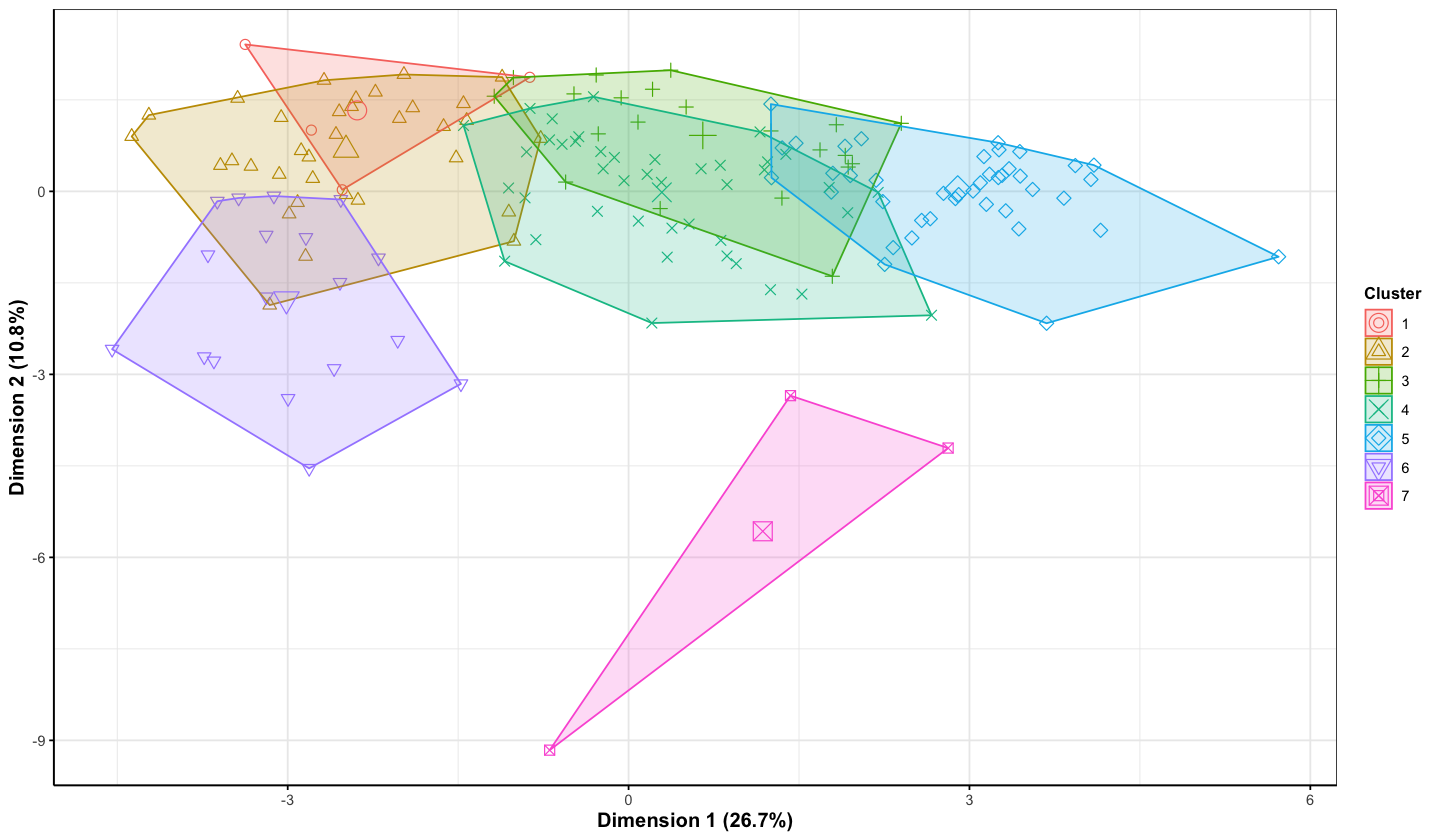

Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


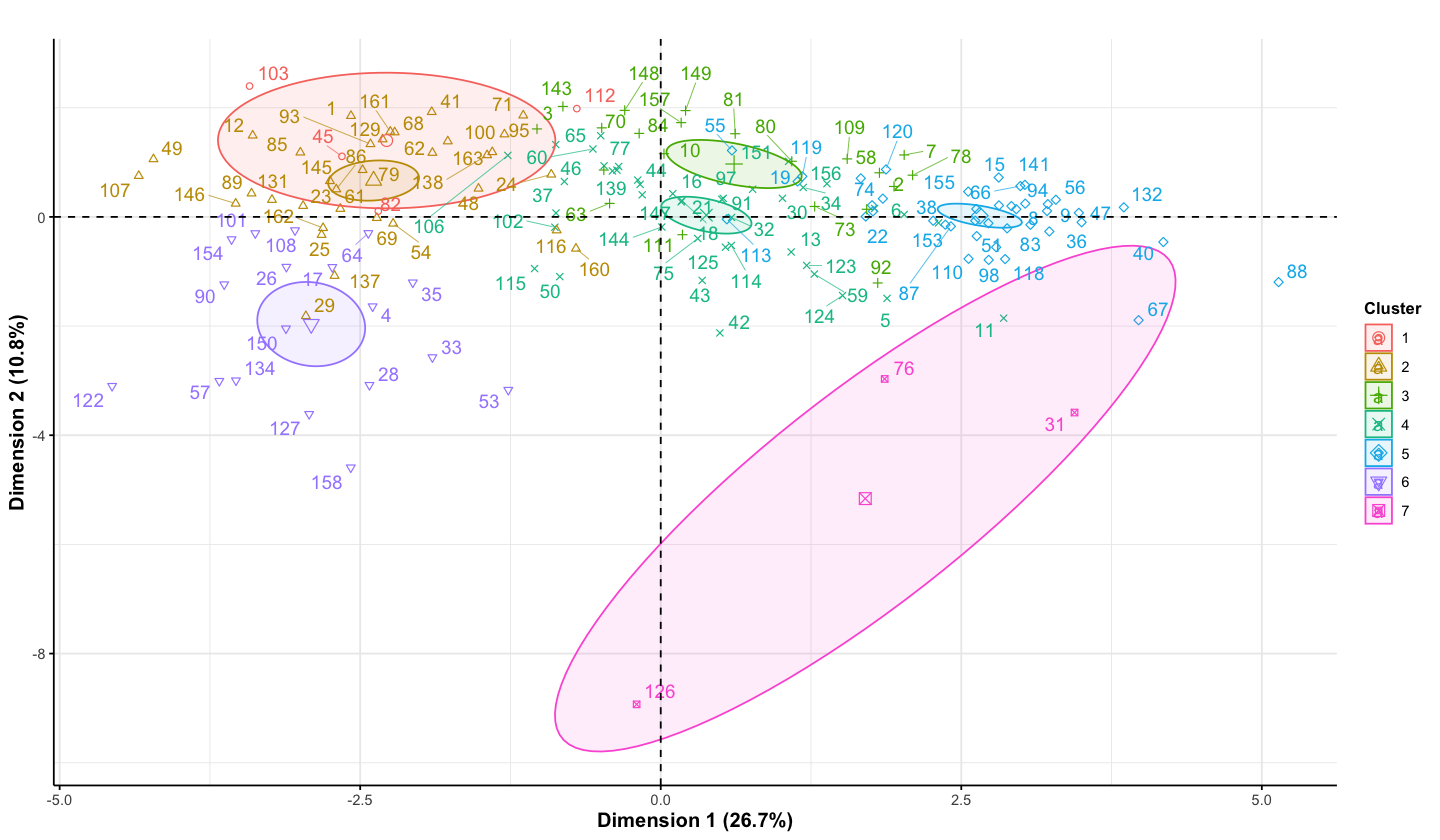

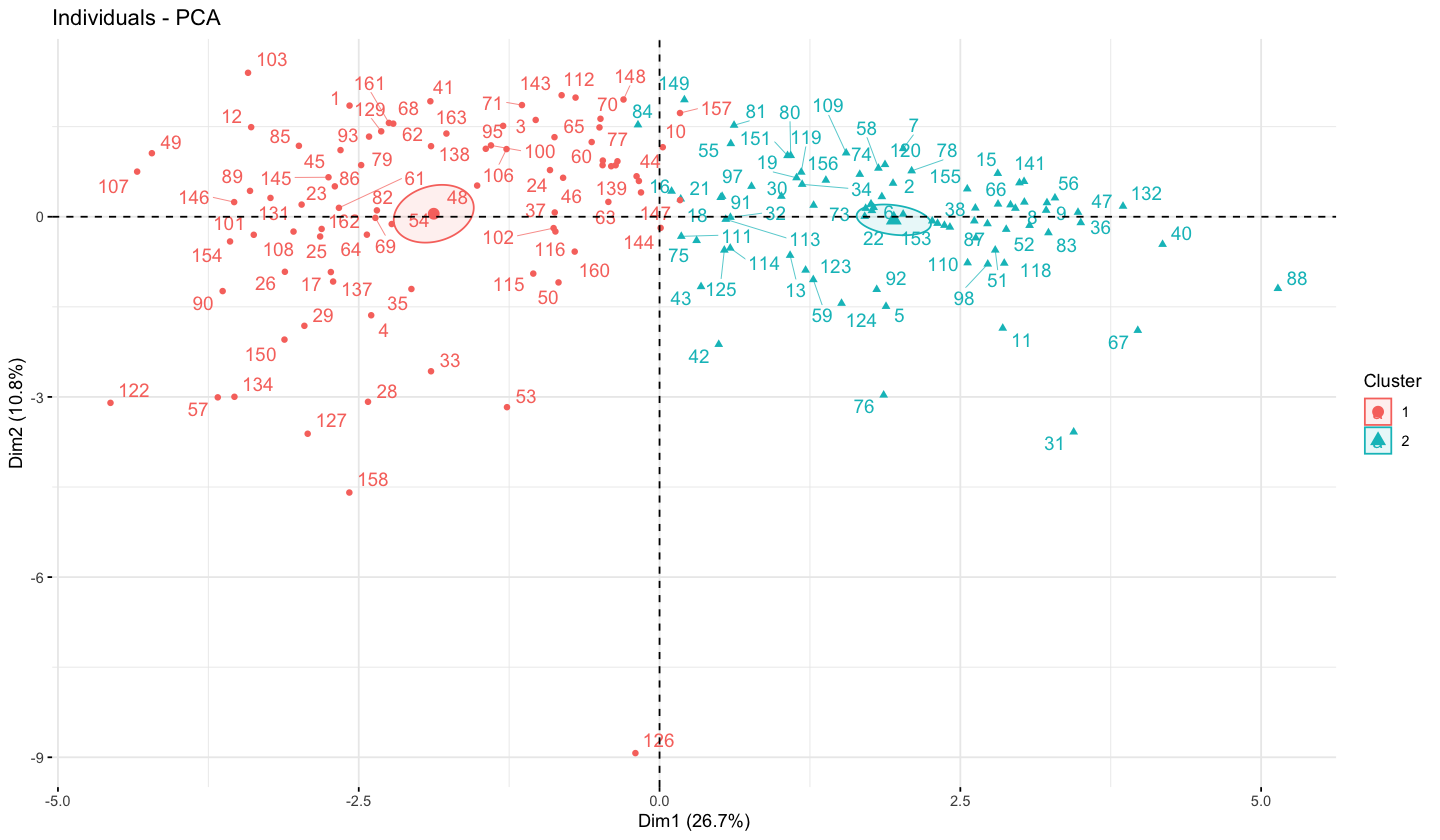

In [9]:
#visualization of kmeans clusters with lowest BIC
kmeans_clusters = fviz_cluster(clus[[7]], data = scaled_food_data, show.clust.cent = TRUE, geom = "point", #removing labels
                      pointsize = 2.5, repel = TRUE, main = FALSE, ggtheme = theme_bw(), 
                      legend.title = "Cluster") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 10, face = "bold"),
      axis.title = element_text(face = "bold", size = rel(1.1))) + #changes axis titles

  labs(x = "Dimension 1 (26.7%)", y = ("Dimension 2 (10.8%)")) 

kmeans_clusters

#seeing if this looks similar to the dichotomous PCA plot that was colored by outcome
pca_clusters = fviz_pca_ind(pca_food_data, 
             col.ind = combined_df_binary$clus, # color by cluster (using cluster # where BIC was minimized)
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             legend.title = "Cluster",
             repel = TRUE, title = "") +
theme(axis.line = element_line(colour = "black"), #making x and y axes black
      legend.title = element_text(size = 10, face = "bold"),
      axis.title = element_text(face = "bold", size = rel(1.1))) + #changes axis titles

  labs(x = "Dimension 1 (26.7%)", y = ("Dimension 2 (10.8%)")) 

pca_clusters

#it isn't so I'm just curious to see what 2 clusters looks like
fviz_pca_ind(pca_food_data, 
             col.ind = factor(clus[[2]]$cluster), # color by cluster (using cluster # where BIC was minimized)
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             legend.title = "Cluster",
             repel = TRUE)

Saving all these results. 

Outcome,CV Error,Std Error,Method
<chr>,<dbl>,<dbl>,<chr>
Cases_vs_median,0.7747549,0.1453971,KNN
Deaths_vs_median,0.7445261,0.1526071,KNN
Confirmed_per_capita,10.0000000,6.0553007,KNN
Deaths_per_capita,11.0000000,6.0553007,KNN


Warning message:
“ggrepel: 144 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 144 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 146 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


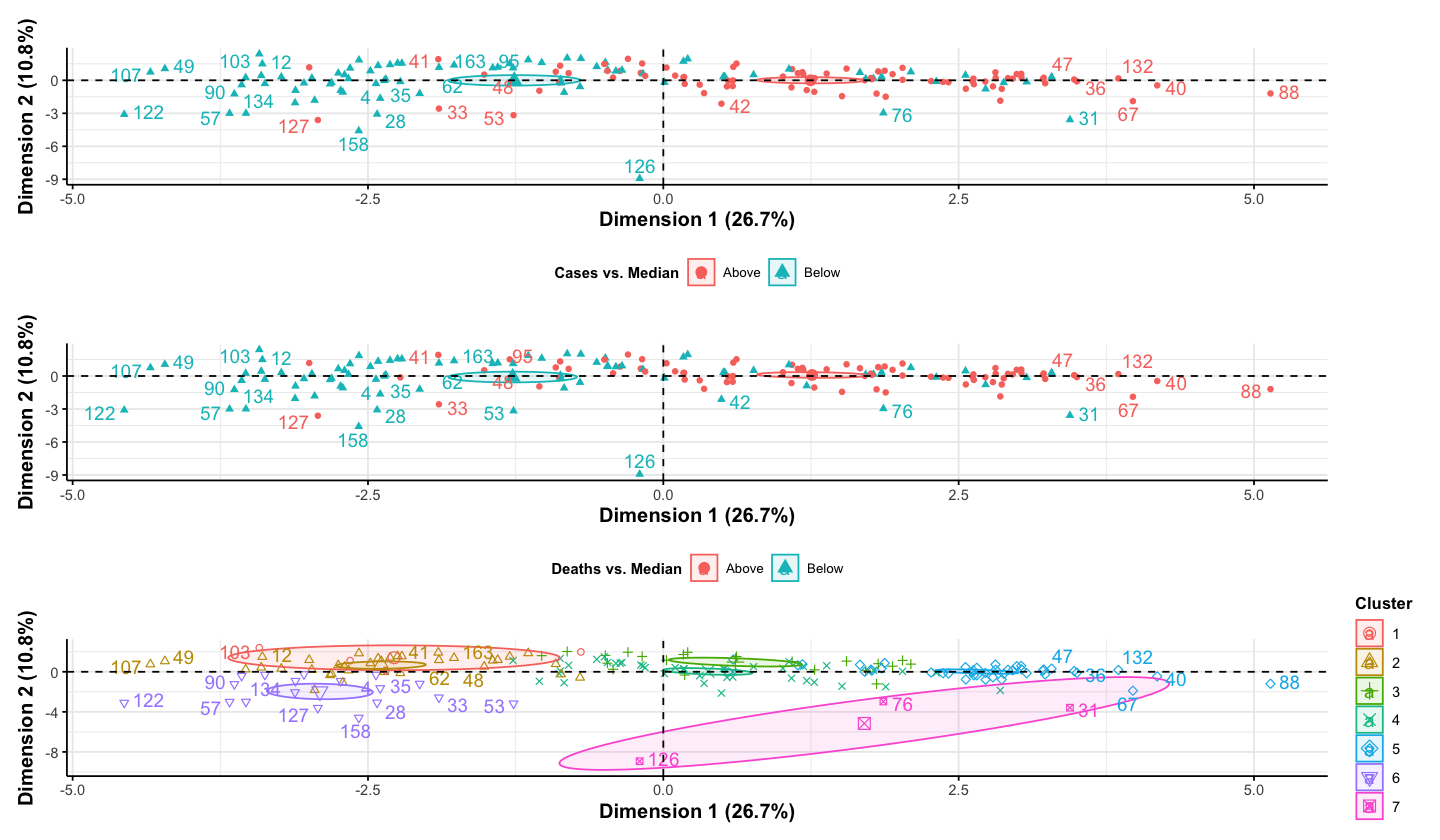

In [10]:
#combinining all KNN results
KNN_results = rbind(errors_binary, errors_continuous)
KNN_results$Method = rep("KNN", times = length(KNN_results$Outcome))
KNN_results

#combining pca figures
pca_plots = cases_pca_plot + deaths_pca_plot + pca_clusters + plot_layout(ncol = 1)
pca_plots

In [ ]:
#exporting results
write.csv(corr_matrix_df, paste0(Output,"/", "Pearson_Correlations.csv"), row.names = TRUE)
write.csv(KNN_results, paste0(Output,"/", "KNN_PCA_results.csv"), row.names = FALSE)

#saving figures 
ggsave(Loadings_plot, 
       filename = 'Loadings_plot.pdf',
       path = Output,
       width = 12, height = 7)

ggsave(kmeans_clusters, 
       filename = 'Kmeans_clusters.pdf',
       path = Output,
       width = 12, height = 7)

ggsave(pca_plots, 
       filename = 'PCA_plots.pdf',
       path = Output,
       width = 12, height = 20)

ggsave(cases_pca_plot, 
       filename = 'Cases_PCA_plot.pdf',
       path = Output,
       width = 12, height = 7)

ggsave(deaths_pca_plot, 
       filename = 'Deaths_PCA_plot.pdf',
       path = Output,
       width = 12, height = 7)

ggsave(pca_clusters, 
       filename = 'Clusters_PCA_plot.pdf',
       path = Output,
       width = 12, height = 7)